# Causal Inference and Predictive Modeling of Housing Prices  
### *A Comparative Study Using 2SLS, Linear Regression, and Neural Networks*

> Exploring both structural relationships and predictive performance across econometric and machine learning methods.


## Introduction

Understanding the dynamics behind housing prices is essential for policymakers, investors, and economists alike.  
This study explores both the **causal relationships** and **predictive performance** of various factors affecting housing prices in Canada from **1988 to 2020**.

Using a **two-stage least squares (2SLS)** approach, I first investigate how **interest rates influence credit volume**, and in turn, how **credit affects housing prices**.

Beyond causal analysis, I compare traditional **linear regression** , **neural network models**,**lasso** and **desision trees** to compare how well these methods can forecast housing prices.

By combining **econometric techniques** with **machine learning**, this research aims to bridge the gap between **interpretation** and **prediction**, providing a more complete picture of what drives changes in the housing market.


## Source of data
All the data sets comes from **Statistics Canada**

| File Name                     | Source Link                                                                                                                   | Description                                                                                                                     |
|------------------------------|--------------------------------------------------------------------------------------------------------------------------------|---------------------------------------------------------------------------------------------------------------------------------|
| `CPI.csv`                    | [Link](https://www150.statcan.gc.ca/t1/tbl1/en/tv.action?pid=1810000401)                                                      | Consumer Price Index, monthly, not seasonally adjusted                                                                          |
| `houseindex.csv`             | [Link](https://www150.statcan.gc.ca/t1/tbl1/en/tv.action?pid=1810020501)                                                      | New housing price index, monthly                                                                                                |
| `mortgagecredit.csv`         | [Link](https://www150.statcan.gc.ca/t1/tbl1/en/tv.action?pid=1010012901)                                                      | Residential mortgage credit (in millions), outstanding balances from major private lenders, Bank of Canada                     |
| `unemplyed.csv`              | [Link](https://www150.statcan.gc.ca/t1/tbl1/en/tv.action?pid=1410002101)                                                      | Unemployment, participation, and employment rates by type of student, monthly, unadjusted for seasonality                      |
| `mortgagerate.csv`           | [Link](https://www150.statcan.gc.ca/t1/tbl1/en/tv.action?pid=3410014501)                                                      | CMHC, conventional mortgage lending rate, 5-year term                                                                           |
| `newhomes.csv`, `newcondos.csv` | [Link](https://www150.statcan.gc.ca/t1/tbl1/en/tv.action?pid=3410015201)                                                  | CMHC housing starts by dwelling type and market type in centres with 50,000+ population, for Canada and provinces              |


### 1. Import library

In [161]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from linearmodels.iv import IV2SLS
import statsmodels.api as sm

In [162]:
CPI_D = pd.read_csv('CPI.csv',encoding='utf-8-sig')
HOUSE_INDEX = pd.read_csv('houseindex.csv',encoding='utf-8-sig')
MORTAGECREDIT = pd.read_csv('mortgagecredit.csv',encoding='utf-8-sig')
MORTAGERATE = pd.read_csv('mortgagerate.csv',encoding='utf-8-sig')
NEW_HOME_SALES = pd.read_csv('newhomes.csv',encoding='utf-8-sig')
NEW_CONDOS = pd.read_csv('newcondos.csv',encoding='utf-8-sig')
UNEMPLOYED = pd.read_csv('unemplyed.csv',encoding='utf-8-sig')


In [163]:
df = pd.merge(CPI_D, HOUSE_INDEX, on='REF_DATE', how='outer')  
df = pd.merge(df, MORTAGECREDIT, on='REF_DATE', how='outer') 
df = pd.merge(df, MORTAGERATE, on='REF_DATE', how='outer')  
df = pd.merge(df, NEW_HOME_SALES, on='REF_DATE', how='outer')  
df = pd.merge(df, NEW_CONDOS, on='REF_DATE', how='outer') 
df = pd.merge(df, UNEMPLOYED, on='REF_DATE', how='outer')
df['REF_DATE'] = pd.to_datetime(df['REF_DATE']) 
df['TimeTrend'] = np.arange(1, len(df) + 1)
df['CREDIT_Growth'] = (df['CREDIT'] - df['CREDIT'].shift(1)) / df['CREDIT'].shift(1) * 100
df = df.dropna()  
df['TimeTrend'] = df['TimeTrend'] - 394
df['CREDIT'] = df['CREDIT'] / 10000 #Now the unit is 10 billion CAD



## Data overview

In [164]:
df

,REF_DATE,CPI,HINDEX,CREDIT,MRATE,HNUM,CNUM,URATE,TimeTrend,CREDIT_Growth
394,1988-11-01,72.3,55.0,19.2308,11.78,8318.0,3844.0,10.2,1,1.060487
395,1988-12-01,72.3,55.8,19.4579,12.13,7249.0,2670.0,9.8,2,1.180918
396,1989-01-01,72.7,56.3,19.6837,12.24,5990.0,4667.0,11.3,3,1.160454
397,1989-02-01,73.2,57.7,19.9273,12.23,5024.0,2137.0,11.1,4,1.237572
398,1989-03-01,73.6,58.6,20.1617,12.41,6423.0,3310.0,11.0,5,1.176276
...,...,...,...,...,...,...,...,...,...,...
768,2020-01-01,136.8,103.4,164.0113,4.08,4000.0,2806.0,8.8,375,0.368093
769,2020-02-01,137.4,103.8,164.4740,4.08,4302.0,4021.0,8.9,376,0.282115
770,2020-03-01,136.6,104.1,165.2870,3.90,4655.0,4196.0,15.1,377,0.494303
771,2020-04-01,135.7,104.1,166.2719,3.95,3603.0,5444.0,22.6,378,0.595873


### Description of variables

| Variable    | Description                          |
|-------------|--------------------------------------|
| REF_DATE    | Observation date (YYYY-MM-DD)        |
| CPI         | Consumer Price Index (inflation)     |
| HINDEX      | Housing market index (target)        |
| CREDIT      | Total housing credit available  (unit is 10 billion CAD)     |
| MRATE       | Mortgage interest rate (%)           |
| HNUM        | Number of new homes                  |
| CNUM        | Number of new condos                 |
| URATE       | Unemployment rate (%)                |
| TimeTrend   | Monthly counter (1 = Nov 1988)       |

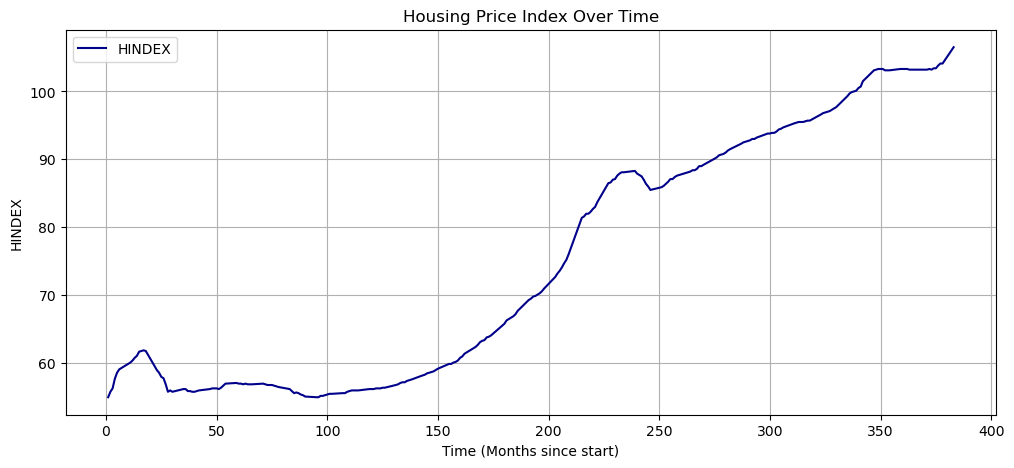

In [165]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))
plt.plot(df["TimeTrend"], df["HINDEX"], label="HINDEX", color="darkblue")
plt.title("Housing Price Index Over Time")
plt.xlabel("Time (Months since start)")
plt.ylabel("HINDEX")
plt.grid(True)
plt.legend()
plt.show()


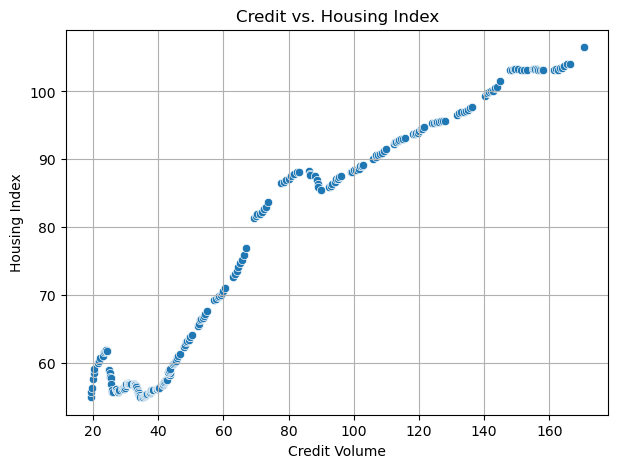

In [166]:
import seaborn as sns

plt.figure(figsize=(7, 5))
sns.scatterplot(x="CREDIT", y="HINDEX", data=df)
plt.title("Credit vs. Housing Index")
plt.xlabel("Credit Volume")
plt.ylabel("Housing Index")
plt.grid(True)
plt.show()


## Interpreting the Credit vs. Housing Price Scatterplot

The scatterplot shows a clear **non-linear relationship** between credit volume and the housing index.  
I think one of thr possible explanation lies in the **different response speeds** of these two variables.

Housing prices tend to react quickly to shifts in **market sentiment** and **expectations**.  
In contrast, **credit volume**—particularly mortgage lending—adjusts more **slowly**, largely because it’s built on existing stock.  
Most outstanding mortgages don’t change overnight, and new lending is constrained by **approval processes**, **bank risk management**, and **regulatory conditions**.

---

In the **lower range of credit volume**, we already see significant jumps in housing prices.  
This suggests that prices were **responding rapidly** to changing market conditions—perhaps  a **surge in demand**—while the credit stock had not yet caught up.

Later, as credit volume **gradually rises**, the housing index continues to increase but at a **slower pace**.  
That likely reflects the **delayed expansion of credit** following earlier price shifts, as the financial system slowly channels more funds into the housing market.

---

**Conclusion:**  
The shape of the graph supports the idea that **prices move fast, while credit moves slow**—a dynamic consistent with the **structural inertia** of lending systems.


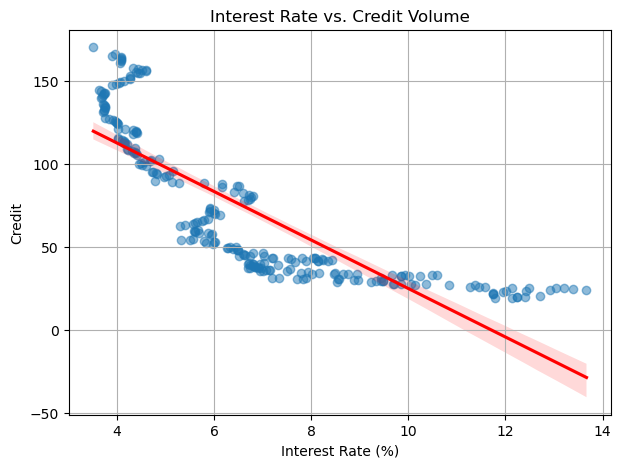

In [167]:
plt.figure(figsize=(7, 5))
sns.regplot(x="MRATE", y="CREDIT", data=df, scatter_kws={"alpha": 0.5},line_kws={"color": "red"})
plt.title("Interest Rate vs. Credit Volume")
plt.xlabel("Interest Rate (%)")
plt.ylabel("Credit")
plt.grid(True)
plt.show()


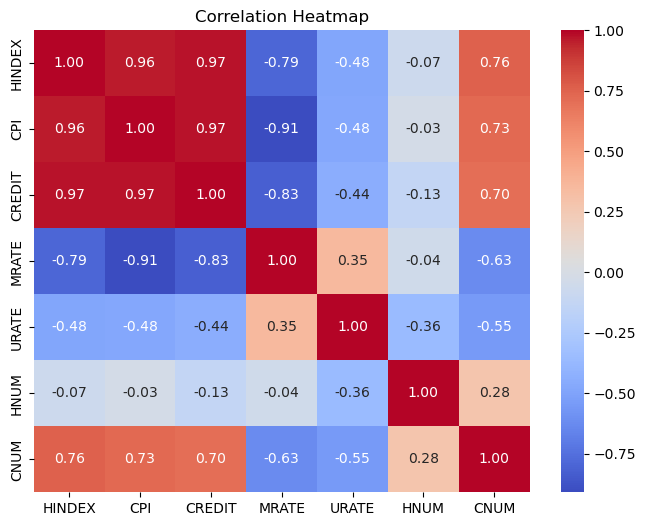

In [168]:
plt.figure(figsize=(8, 6))
corr = df[["HINDEX", "CPI", "CREDIT", "MRATE", "URATE", "HNUM", "CNUM"]].corr()
sns.heatmap(corr, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Heatmap")
plt.show()


## Use interest rate as an instrument to predict housing price via credit (Two-Stage Least Squares)

---

### First Stage  
Use the instrument (interest rate) to predict the endogenous variable (credit):

$$
\text{CREDIT}_t = \alpha_0 + \alpha_1 \cdot \text{MRATE}_t + \alpha_2 \cdot \text{Controls}_t + \alpha_3 \cdot \text{TimeTrend}_t + u_t
$$

- **Endogenous variable**: `CREDIT`
- **Instrumental variable**: `MRATE` (interest rate)
- **Control variables**: e.g., `URATE`, `HNUM`, `CPI`, `CNUM`, etc.
- **Time trend**: added to account for structural shifts over time

---

### Second Stage  
Use the predicted credit from stage one to estimate the housing price index:

$$
\text{HINDEX}_t = \beta_0 + \beta_1 \cdot \hat{\text{CREDIT}}_t + \beta_2 \cdot \text{Controls}_t + \beta_3 \cdot \text{TimeTrend}_t + \varepsilon_t
$$

- **Dependent variable (Y)**: `HINDEX` (housing price index)
- **$\hat{\text{CREDIT}}$**: fitted values from the first stage regression

---




### Causal Impact of Credit Volume on Housing Prices

To explore the causal impact of credit volume on housing prices, this study adopts the **Two-Stage Least Squares (2SLS)** approach. The motivation for using this method is due to the likely **endogeneity** of credit volume (CREDIT) in the housing price equation. This means that credit volume might be influenced by unobserved factors that also affect housing prices. These factors could include:

- Macroeconomic shocks
- Measurement errors
- Reverse causality (e.g., rising housing prices encouraging more lending)

Because of this endogeneity, using **Ordinary Least Squares (OLS)** could lead to **biased or inconsistent estimates**. To address this issue, we use the **market interest rate (MRATE)** as an instrumental variable for CREDIT.

### Why MRATE is a good instrument for CREDIT:

1. **Relevance**: Interest rates are closely related to credit volume. As interest rates increase, borrowing becomes more expensive, which generally reduces the overall volume of credit in the economy.
  
2. **Exogeneity**: Interest rates, particularly those set through monetary policy, are largely **exogenous** to local housing prices. They affect housing indirectly through credit conditions, not directly. Therefore, MRATE meets the **exclusion restriction** — it impacts housing prices only through its effect on credit.

By using MRATE as an instrument, we can obtain more accurate estimates of the causal effect of credit volume on housing prices.


In [169]:
controls = ['URATE', 'HNUM', 'CPI', 'TimeTrend', 'CNUM', 'CREDIT_Growth']
Y = 'HINDEX'
endog = 'CREDIT'
instrument = 'MRATE'
control_vars = '+'.join(controls)
formula = f"{Y} ~ 1 + [{endog} ~ {instrument}] + {control_vars}"
iv_model = IV2SLS.from_formula(formula, data=df).fit(cov_type='robust')
print(iv_model.summary)

                          IV-2SLS Estimation Summary                          
Dep. Variable:                 HINDEX   R-squared:                      0.9675
Estimator:                    IV-2SLS   Adj. R-squared:                 0.9666
No. Observations:                 255   F-statistic:                    9340.4
Date:                Sat, May 10 2025   P-value (F-stat)                0.0000
Time:                        19:49:21   Distribution:                  chi2(7)
Cov. Estimator:                robust                                         
                                                                              
                               Parameter Estimates                               
               Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
---------------------------------------------------------------------------------
Intercept        -9.3782     12.239    -0.7663     0.4435     -33.365      14.609
URATE            -0.3676     0.1559    -

### I. Model valuation

| Item                     | Description |
|--------------------------|-------------|
| **R-squared**            | 0.9576 — Proportion of variance in `HINDEX` explained by the model. 0.9576 indicated my model has strong explanatory power. |
| **Adjusted R-squared**   | 0.9565 — Adjusted for the number of predictors; confirms high model fit while penalizing overfitting. |
| **F-statistic**          | 7545.2 — The extremely high F-statistic indicates that the explanatory variables jointly have strong explanatory power for the dependent variable. |
| **P-value (F-stat)**     | 0.0000 — Indicates the null hypothesis (that all coefficients are zero) is strongly rejected. It shows this model is legit. |


In [170]:
print(iv_model.first_stage)


    First Stage Estimation Results    
                                CREDIT
--------------------------------------
R-squared                       0.9727
Partial R-squared               0.3389
Shea's R-squared                0.3389
Partial F-statistic             109.95
P-value (Partial F-stat)        0.0000
Partial F-stat Distn           chi2(1)
========================== ===========
Intercept                      -199.00
                             (-6.6563)
URATE                           1.2530
                              (3.4906)
HNUM                           -0.0017
                             (-5.7260)
CPI                             1.6368
                              (3.4943)
TimeTrend                       0.2625
                              (3.1302)
CNUM                            0.0008
                              (1.4391)
CREDIT_Growth                   0.4180
                              (0.2226)
MRATE                           6.5030
                         

In [189]:
import pandas as pd
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant

# 假设 df 是你的数据框
# 添加常数项（截距）到数据中
X = add_constant(df[[ 'CPI','CREDIT', 'HNUM','CNUM','URATE','TimeTrend','CREDIT_Growth']])

# 计算每个变量的 VIF
vif_data = pd.DataFrame()
vif_data["Variable"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

# 输出 VIF 值
print(vif_data)


        Variable          VIF
0          const  4370.727100
1            CPI   278.826348
2         CREDIT    24.194297
3           HNUM     1.807813
4           CNUM     3.097630
5          URATE     1.902711
6      TimeTrend   234.992513
7  CREDIT_Growth     1.265554


### Linear regression prediction

In [171]:
from sklearn import (           
    linear_model, metrics, neural_network, pipeline, model_selection
)
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import cross_val_score

In [172]:
df2 = df.copy()
X = df2[[ 'CPI','CREDIT', 'HNUM','CNUM','URATE','TimeTrend','CREDIT_Growth']].values
y = df2['HINDEX'].values
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=0.25,random_state=99)
features = [ 'CPI','CREDIT','HNUM','CNUM','URATE','TimeTrend','CREDIT_Growth']


In [173]:
model = linear_model.LinearRegression()
model.fit(X_train, y_train)
coefficients = pd.Series(model.coef_, index=features)
print("Coefficients:\n", coefficients)
print("Intercept:", model.intercept_)
print("R-squared:", model.score(X_test, y_test))
y_pred = model.predict(X_test)
print("MSE:", mean_squared_error(y_test, y_pred))
baseline_mse = np.mean((y_test - np.mean(y_train))**2)
print("Baseline MSE:", baseline_mse)

Coefficients:
 CPI              0.990942
CREDIT           0.308181
HNUM            -0.000292
CNUM             0.000819
URATE           -0.364514
TimeTrend       -0.136773
CREDIT_Growth    5.324946
dtype: float64
Intercept: -26.486674693877816
R-squared: 0.9621798050445981
MSE: 11.646338184745405
Baseline MSE: 308.4749784947986


In [174]:
cv_model = LinearRegression()
cv_scores =cross_val_score(cv_model, X, y, cv=10, scoring='neg_mean_squared_error')
cv_mse_scores = -cv_scores  
print("Cross-validated MSE scores:", cv_mse_scores)
print("Mean CV MSE:", -np.mean(cv_scores))


Cross-validated MSE scores: [93.86720129  1.44500121  7.92890971 13.78480466 19.83746391 20.63520274
 41.27750855  5.14440239  1.41665871 73.89131414]
Mean CV MSE: 27.92284673123251


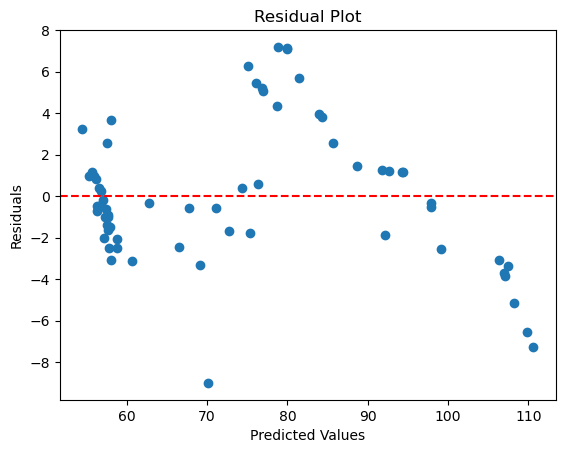

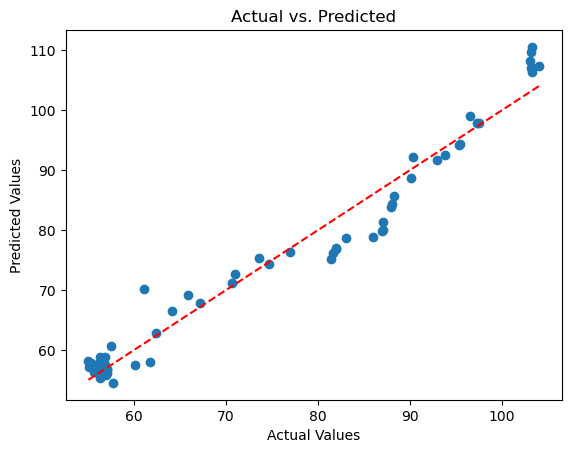

In [175]:
import matplotlib.pyplot as plt

# 1. Residual Plot
plt.scatter(y_pred, y_test - y_pred)
plt.xlabel("Predicted Values")
plt.ylabel("Residuals")
plt.axhline(y=0, color='r', linestyle='--')
plt.title("Residual Plot")
plt.show()

# 2. Actual vs. Predicted
plt.scatter(y_test, y_pred)
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], 'r--')
plt.title("Actual vs. Predicted")
plt.show()

# Ridge

In [194]:
from sklearn.linear_model import Ridge

In [197]:
ridge_model = Ridge(alpha=1.0)  # alpha 是正则化参数，控制惩罚的强度
ridge_model.fit(X_train, y_train)

# 在测试集上进行预测
y_pred_ridge = ridge.predict(X_test)

# 计算均方误差
mse = mean_squared_error(y_test,y_pred_ridge)
print(f'Ridge Mean Squared Error: {mse}')

Ridge Mean Squared Error: 11.611161561899536


In [198]:
coefficients = pd.Series(ridge_model.coef_, index=features)
print("Coefficients:\n", coefficients)

# 输出截距项
print("Intercept:", ridge_model.intercept_)

# 输出 R-squared
print("R-squared:", ridge_model.score(X_test, y_test))

# 使用 Ridge 回归模型进行预测
y_pred_ridge = ridge_model.predict(X_test)

# 输出均方误差
print("MSE:", mean_squared_error(y_test, y_pred_ridge))

# 基准 MSE
baseline_mse = mean_squared_error(y_test, [y_train.mean()] * len(y_test))
print("Baseline MSE:", baseline_mse)

Coefficients:
 CPI              0.989541
CREDIT           0.309074
HNUM            -0.000279
CNUM             0.000839
URATE           -0.365161
TimeTrend       -0.137317
CREDIT_Growth    4.985387
dtype: float64
Intercept: -26.25191775358398
R-squared: 0.9622940372361075
MSE: 11.611161561899536
Baseline MSE: 308.4749784947986


### Lasso

In [176]:
from sklearn.linear_model import Lasso

In [177]:
lasso_model = Lasso(alpha=0.1, max_iter=10000)
lasso_model.fit(X_train, y_train)
coefficients = pd.Series(lasso_model.coef_, index=features)
print("Coefficients:\n", coefficients)
print("Intercept:", lasso_model.intercept_)
print("R-squared:", lasso_model.score(X_test, y_test))
y_pred_lasso = lasso_model.predict(X_test)
print("MSE:", mean_squared_error(y_test, y_pred))
print("Baseline MSE:", baseline_mse)



Coefficients:
 CPI              0.893336
CREDIT           0.314942
HNUM            -0.000242
CNUM             0.000931
URATE           -0.313060
TimeTrend       -0.125035
CREDIT_Growth    4.049484
dtype: float64
Intercept: -19.51972987843483
R-squared: 0.9614698455160118
MSE: 11.646338184745405
Baseline MSE: 308.4749784947986


In [178]:
mse_scores = cross_val_score(lasso_model, X_train, y_train, cv=5, scoring='neg_mean_squared_error')
r2_scores = cross_val_score(lasso_model,X_train, y_train, cv=5, scoring='r2')

# Print results
print("Cross-validated MSE (negative):", mse_scores)
print("Mean Cross-validated MSE:", -np.mean(mse_scores)) 
print("Cross-validated R-squared:", r2_scores)
print("Mean Cross-validated R-squared:", np.mean(r2_scores))


Cross-validated MSE (negative): [ -9.02241256 -10.38731209  -8.2280198  -13.94385087  -9.57439503]
Mean Cross-validated MSE: 10.231198070052699
Cross-validated R-squared: [0.96703729 0.97090678 0.97063935 0.95643916 0.97390878]
Mean Cross-validated R-squared: 0.967786274614108


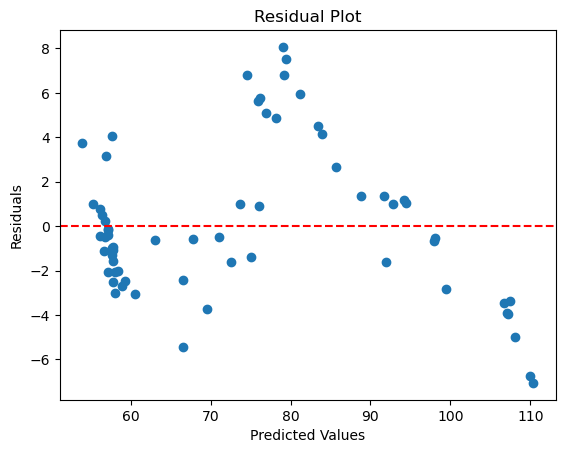

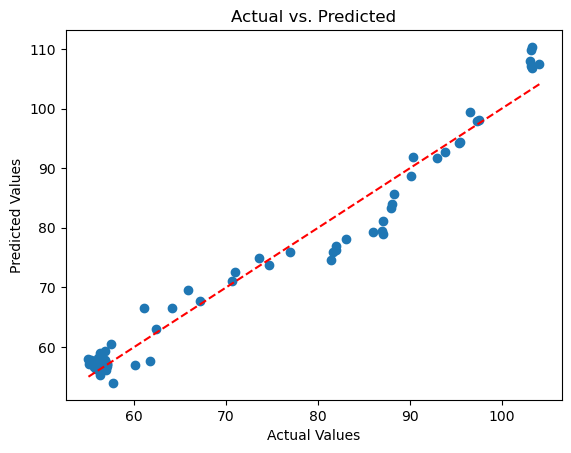

In [179]:
plt.scatter(y_pred_lasso, y_test -y_pred_lasso)
plt.xlabel("Predicted Values")
plt.ylabel("Residuals")
plt.axhline(y=0, color='r', linestyle='--')
plt.title("Residual Plot")
plt.show()

# 2. Actual vs. Predicted
plt.scatter(y_test, y_pred_lasso)
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], 'r--')
plt.title("Actual vs. Predicted")
plt.show()

In [180]:
from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

In [181]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# train 
mlp = MLPRegressor(hidden_layer_sizes=(32, 16), max_iter=10000, random_state=42)
mlp.fit(X_train_scaled, y_train)

# predict 
y_pred_neu = mlp.predict(X_test_scaled)

#  mean squared error
model_mse = mean_squared_error(y_test,y_pred_neu)
print("Model MSE:", model_mse)


print("Baseline MSE:", baseline_mse)

# compare with baseline MSE
improvement = baseline_mse - model_mse
print("Improvement over baseline:", improvement)

Model MSE: 4.645124350627623
Baseline MSE: 308.4749784947986
Improvement over baseline: 303.829854144171


In [182]:
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('mlp', MLPRegressor(
        hidden_layer_sizes=(32, 16),
        max_iter=10000,
        early_stopping=True,
        validation_fraction=0.1,
        n_iter_no_change=1000,
        random_state=42
    ))
])

# cross-validation
cv_scores_neu = cross_val_score(pipeline, X, y, cv=10, scoring='neg_mean_squared_error', n_jobs=-1)

# output
print("Cross-Validation MSE:", -cv_scores_neu)
print("Mean CV MSE:", -np.mean(cv_scores_neu))  
print("Standard Deviation of CV MSE:", np.std(cv_scores_neu))

Cross-Validation MSE: [ 21.53686746   0.51114934   0.52174436   4.87756118   6.97340694
   6.13802465   4.98652812   0.64061044   0.84498899 135.623134  ]
Mean CV MSE: 18.265401546671743
Standard Deviation of CV MSE: 39.56998849378999


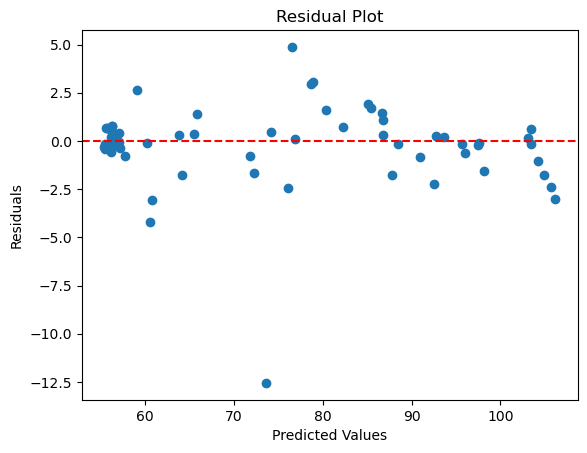

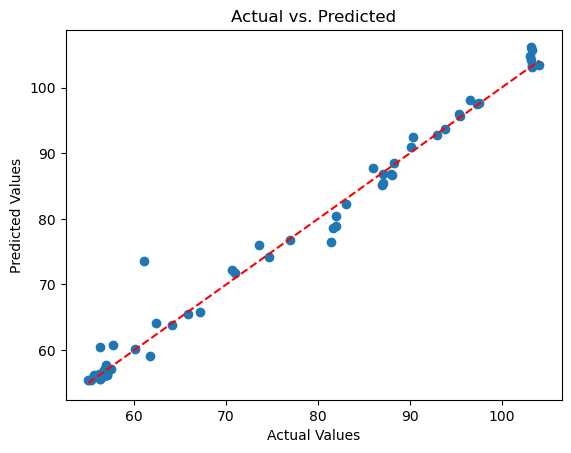

In [183]:
# 1. Residual Plot
plt.scatter(y_pred_neu, y_test - y_pred_neu)
plt.xlabel("Predicted Values")
plt.ylabel("Residuals")
plt.axhline(y=0, color='r', linestyle='--')
plt.title("Residual Plot")
plt.show()

# 2. Actual vs. Predicted
plt.scatter(y_test, y_pred_neu)
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], 'r--')
plt.title("Actual vs. Predicted")
plt.show()

In [184]:
from sklearn.tree import DecisionTreeRegressor

In [185]:
tree = DecisionTreeRegressor(max_depth=4, random_state=0)
tree.fit(X_train, y_train)
y_pred_tree = tree.predict(X_test)

print("Decision Tree R^2:", r2_score(y_test, y_pred_tree))
print("Decision Tree MSE:", mean_squared_error(y_test, y_pred_tree))

Decision Tree R^2: 0.9969855265192817
Decision Tree MSE: 0.9282759553934294


In [186]:
pipeline = Pipeline([
    ('tree', DecisionTreeRegressor(
        max_depth=5,         
        min_samples_leaf=5,  
        random_state=42
    ))
])

# Cross-validation:
cv_scores_tree = cross_val_score(pipeline, X, y, cv=10, scoring='neg_mean_squared_error', n_jobs=-1)

# Output 
print("Cross-Validation MSE:", -cv_scores_tree)
print("Mean CV MSE:", -np.mean(cv_scores_tree))
print("Standard Deviation of CV MSE:", np.std(cv_scores_tree))

Cross-Validation MSE: [ 7.89141132  0.41723477  1.20965149  3.03858096 15.80896543 19.21464842
  3.98672     5.92140278  8.08707347 11.00145625]
Mean CV MSE: 7.657714489870879
Standard Deviation of CV MSE: 5.858793584577677


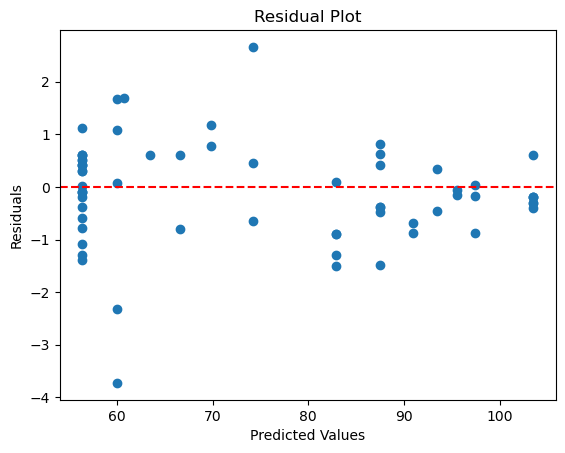

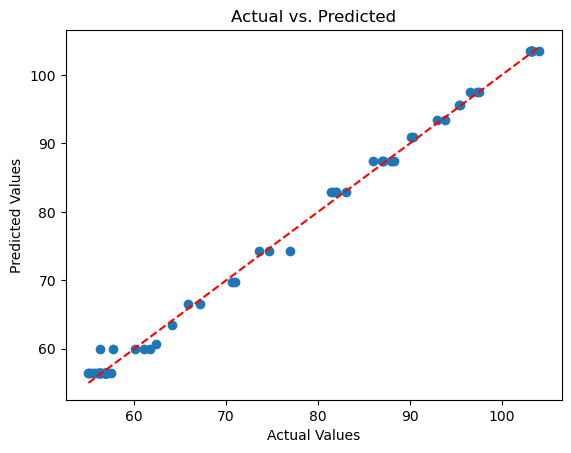

In [187]:
plt.scatter(y_pred_tree, y_test - y_pred_tree)
plt.xlabel("Predicted Values")
plt.ylabel("Residuals")
plt.axhline(y=0, color='r', linestyle='--')
plt.title("Residual Plot")
plt.show()

# 2. Actual vs. Predicted
plt.scatter(y_test, y_pred_tree)
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], 'r--')
plt.title("Actual vs. Predicted")
plt.show()

# Limitation and discussion

### Use of CPI in Explaining Housing Prices

Including the Consumer Price Index (CPI) in a housing price model raises an important modeling choice. On the one hand, CPI includes housing-related costs such as mortgage interest, utilities, and property taxes—components that are clearly tied to the cost of living. However, these expenses can also move with housing prices, especially mortgage interest costs, which may rise when home values go up or interest rates change. This opens the door to potential endogeneity: if housing prices influence CPI and we use CPI to explain housing prices, we risk creating a feedback loop that biases our estimates.

It's important to note that CPI does not directly capture housing asset prices. Unlike housing price indices like HINDEX, which reflect changes in the market value of homes, CPI focuses on the recurring expenses of living in a home. For this reason, using CPI can still be useful—it gives us a way to account for broader inflationary pressure and economic conditions that likely influence the housing market.

Although the CPI includes housing-related expenditures (such as mortgage interest costs and property taxes), it does not directly reflect housing asset prices. Including CPI as a regressor allows us to capture the effect of broader living costs and inflationary pressure on housing price dynamics. However, we remain cautious of potential endogeneity due to overlapping channels and test the robustness of our results accordingly.

Looking ahead, future research might consider using core CPI (which excludes shelter) or disaggregating CPI components to focus on non-housing inflation. This could reduce the risk of bias while keeping the benefits of capturing inflationary trends in the economy.


## Appendix
GPT is used: https://chatgpt.com/share/68194ba3-f870-8000-9022-364f2a6f1639